In [1]:
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
reviews = pd.read_csv('../data/reviews_final.csv')
reviews.head()

,title,review,rating,date,label
0,Ótimo custo benefício.,Até agora estou amando o aparelho. Estou bem s...,5.0,25/10/2019,Good
1,Não recebi a versão global e produto veio sem ...,"Adquiri o produto em 09/11, chegou hoje e para...",1.0,14/11/2019,Bad
2,"Bom, bonito e barato. Porém sem nota fiscal!",Comprei o celular no sábado dia 26/10/19 e che...,5.0,31/10/2019,Good
3,"Bom, no prazo, carregador fora do padrão brasi...","Chegou dentro do prazo, bem embalado. Tudo ok,...",3.0,19/11/2019,Neutral
4,Celular acima das expectativas,O celular superou totalmente minhas expectativ...,5.0,29/10/2019,Good


In [3]:
df_pred = pd.read_csv('../data/model_2_preds.txt', header=None)
df_pred.head()

,0
0,1
1,1
2,1
3,1
4,1


In [4]:
# Label 0 corresponds to Bad
# Label 1 corresponds to Good
# Label 2 corresponds to Neutral

def rename_label(x):
    if(x[0] == 1):
        x[0] = 'Good'
    elif(x[0] == 0):
        x[0] = 'Bad'
    elif(x[0] == 2):
        x[0] = 'Neutral'
    
    return x

In [5]:
df_pred = df_pred.apply(rename_label, axis=1)

In [6]:
X = reviews['date']
y = reviews['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [7]:
reviews_test = pd.DataFrame(zip(X_test, y_test, df_pred[0]), columns=['date', 'label', 'label_pred'])
reviews_test.head()

,date,label,label_pred
0,14/03/2020,Good,Good
1,7/05/2020,Good,Good
2,27/03/2020,Good,Good
3,24/03/2020,Good,Good
4,7/07/2021,Good,Good


In [8]:
reviews_test['date'] = pd.to_datetime(reviews_test['date'], dayfirst=True)

In [9]:
reviews_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1431 non-null   datetime64[ns]
 1   label       1431 non-null   object        
 2   label_pred  1431 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 33.7+ KB


In [10]:
reviews_test.head()

,date,label,label_pred
0,2020-03-14,Good,Good
1,2020-05-07,Good,Good
2,2020-03-27,Good,Good
3,2020-03-24,Good,Good
4,2021-07-07,Good,Good


In [11]:
def get_month(date):
    return date.strftime("%b")

reviews_test['month'] = reviews_test.date.apply(get_month)
reviews_test.head()

,date,label,label_pred,month
0,2020-03-14,Good,Good,Mar
1,2020-05-07,Good,Good,May
2,2020-03-27,Good,Good,Mar
3,2020-03-24,Good,Good,Mar
4,2021-07-07,Good,Good,Jul


In [12]:
def get_year(date):
    return date.strftime("%y")

reviews_test['year'] = reviews_test.date.apply(get_year)
reviews_test.head()

,date,label,label_pred,month,year
0,2020-03-14,Good,Good,Mar,20
1,2020-05-07,Good,Good,May,20
2,2020-03-27,Good,Good,Mar,20
3,2020-03-24,Good,Good,Mar,20
4,2021-07-07,Good,Good,Jul,21


In [17]:
def count_groupby(label):
    counts = pd.DataFrame(reviews_test.groupby(['month', 'year', label])[label].count())
    counts.columns = ['count']
    counts = counts.reset_index()
    new_dates = []

    for row in counts.itertuples():
        new_dates.append(f'{row.month}-{row.year}')

    counts['new_date'] = new_dates
    counts['year'] = pd.to_numeric(counts['year'])
    
    counts_filtered = counts.query("year == 20 or year == 21")
    counts_filtered['new_dt'] = pd.to_datetime(counts_filtered['new_date'], format='%b-%y')
    counts_filtered = counts_filtered.sort_values('new_dt')
    
    percentages = []

    for distinct_month_year in counts_filtered.new_date.unique():
        dataset = counts_filtered.query(f'new_date == "{distinct_month_year}"')
        total = sum(dataset['count']) 

        month_year_values = dataset['count'].values

        if month_year_values.size > 0:
            for value in month_year_values:
                percentage = (value * 100)/total
                percentages.append(percentage)
        else:
            pass

    counts_filtered['monthly_perc'] = percentages 
    
    return counts_filtered

In [18]:
counts_pred = count_groupby('label_pred')
counts_label = count_groupby('label')

C:\Users\mtbl\AppData\Local\Temp/ipykernel_8532/208608452.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_filtered['new_dt'] = pd.to_datetime(counts_filtered['new_date'], format='%b-%y')


<AxesSubplot:xlabel='new_date', ylabel='monthly_perc'>

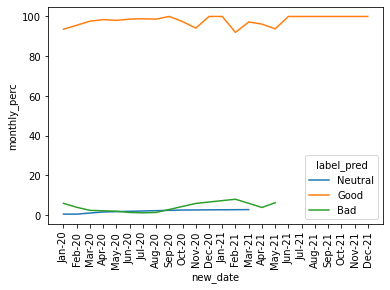

In [19]:
plt.xticks(rotation=90)
sns.lineplot(data=counts_pred, x='new_date', y='monthly_perc', hue='label_pred')

<AxesSubplot:xlabel='new_date', ylabel='monthly_perc'>

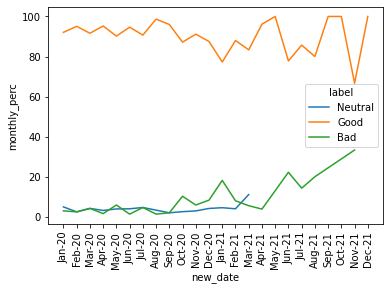

In [20]:
plt.xticks(rotation=90)
sns.lineplot(data=counts_label, x='new_date', y='monthly_perc', hue='label')

In [21]:
counts_pred.to_csv('../data/pred_lstm_count.csv', index=False)
counts_label.to_csv('../data/label_test_count.csv', index=False)